# IEEE Fraud Detection 

By: Michael Mehallow

With support from other Kernels from Kaggle.com

This represents all the necessary steps to create final submission which had the highest Private LB score of my submissions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
import time
import pickle
from sklearn.preprocessing import LabelEncoder

Create function to reduce memory usage

In [7]:
def my_reduce_memory_usage(df):
    for col in df.columns:
        # Get columns data type
        c_type = df[col].dtype
        
        # Only run this section if c_type is an integer
        if str(c_type)[:3] == 'int':
            c_min = df[col].min()
            c_max = df[col].max()

            if c_min >= np.iinfo('int8').min & c_max <= np.iinfo('int8').max:
                df[col] = df[col].astype('int8')
            elif c_min >= np.iinfo('int16').min & c_max <= np.iinfo('int16').max:
                df[col] = df[col].astype('int16')
            elif c_min >= np.iinfo('int32').min & c_max <= np.iinfo('int32').max: 
                df[col] = df[col].astype('int32')
                
        # Run this section to convert floats
        elif str(c_type)[:5] == 'float':
            c_min = df[col].min()
            c_max = df[col].max()

            if (c_min >= np.finfo('float16').min) & (c_max <= np.finfo('float16').max):
                df[col] = df[col].astype('float16')
            elif (c_min >= np.finfo('float32').min) & (c_max <= np.finfo('float32').max): 
                df[col] = df[col].astype('float32')

    return df

Read and reduce memory of train and test data

In [8]:
start = time.time()
train_identity = my_reduce_memory_usage(pd.read_csv('train_identity.csv', index_col='TransactionID'))
end = time.time()
print('Train Identity Elapsed time : ' + str(end-start))

train_transaction = my_reduce_memory_usage(pd.read_csv('train_transaction.csv', index_col='TransactionID'))
end = time.time()
print('Train Elapsed time : ' + str(end-start))

test_identity = my_reduce_memory_usage(pd.read_csv('test_identity.csv', index_col='TransactionID'))
test_transaction = my_reduce_memory_usage(pd.read_csv('test_transaction.csv', index_col='TransactionID'))
end = time.time()

print('Elapsed time : ' + str(end-start))

Train Identity Elapsed time : 3.0520572662353516
Train Elapsed time : 247.04404544830322
Elapsed time : 489.0864336490631


In [10]:
train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
y_train = train['isFraud']
test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)

In [3]:
# Uncomment to overwrite pickle!!!
# with open('train_test.pickle', 'wb') as f:
#    pickle.dump([train, y_train, test], f)

# Leave this as is below to read pickle!!!
# open a file, where you stored the pickled data
file = open('train_test.pickle', 'rb')
train, y_train, test = pickle.load(file)    

## Feature Engineering

In [4]:
# Get Target encode information
targets = {}

for col in ['P_emaildomain', 'R_emaildomain', 'addr1', 'addr2', 'id_19', 'id_20']:
    targets[col] = train.groupby([col])['isFraud'].mean()

Target encode based on card1 and D1

card1 actually represents an account, and can have multiple clients or individual users. Fraud is detected for individual user, thus it is important to group by card1 and D1.

Post Competition: A better way would be to use card1, addr1 and D1 all combined. In addition, if I had more time I would frequency encode based on this.

In [5]:
train['Day'] = train['TransactionDT'] / 86400 
train['D1_Id'] = ((train['D1']// 1 - train['Day']// 1)).fillna(-9999)

targets['card1_D1_Id'] = train.groupby(['card1', 'D1_Id'])['isFraud'].mean()

Combine test and train data sets

In [6]:
# Combine test and train data sets
feature_cols = test.columns
df = pd.concat([train[feature_cols], test[feature_cols]], axis=0).copy()

In [7]:
# Uncomment to overwrite pickle!!!
# Determine columns to keep based on percent of nulls, and other factors
#too_many_nulls_cols = [col for col in df.columns if df[col].isna().mean() > 0.9]
#big_top_value_cols = [col for col in df.columns if df[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
#
#cols_to_drop = too_many_nulls_cols + big_top_value_cols
#cols_to_keep = [x for x in df.columns if x not in cols_to_drop]
#
#with open('keep_drop_cols.pickle', 'wb') as f:
#    pickle.dump([cols_to_keep, cols_to_drop], f)

# Leave this as is below to read pickle!!!
# open a file, where you stored the pickled data
file = open('keep_drop_cols.pickle', 'rb')
cols_to_keep, cols_to_drop = pickle.load(file)    

## Data Pipeline
This includes cleaning and frequency engineering.
### BE VERY CAREFUL HERE

In [8]:
def freq_encoder(df):
    num_rows = len(df)
    fq_encode = (df.value_counts(dropna=False) / num_rows).to_dict()
    df = df.map(fq_encode)
    return df

Fill missing or null values

In [9]:
start = time.time()
#df = df.drop(columns = cols_to_drop)

df['ProductCD'] = df['ProductCD'].fillna('W')

df['card4'] = df['card4'].fillna('na')
df['card4'] = df['card4'].fillna('na')
df['card4'] = df['card4'].fillna('na')
df['card6'] = df['card6'].fillna('debit')

# Set missing values for vesta columns
vesta_columns = [x for x in df.columns if x[0]=='V']  
for feature in vesta_columns:
    df[feature] = df[feature].fillna(-999) 

d_fills = {'D1' : 4, 'D2' : 0,
           'D3' : 8, 'D4' : 23,
           'D5' : 9, 'D6' : 0,
           'D7' : 0, 'D8' : 37.78,
           'D9' : 0.665, 'D10' : 13,
           'D11' : 69, 'D12' : 0,
           'D13' : 0, 'D14' : 0, 'D15' : 50}

delta_columns = ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15']
for feature in delta_columns:
     df[feature] = df[feature].fillna(d_fills[feature])   
        
# Impute missing values for id columsn
df['id_01'] = df['id_01'].fillna(99)

Frequency encode C columns

In [11]:
# Frequency Encode C columns
C_freq_encode_cols = ['C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14']
num_rows = len(df)
for col in C_freq_encode_cols:
    fq_encode = (df[col].value_counts(dropna=False) / num_rows).to_dict()   
    df[col + '_fq_enc'] = df[col].map(fq_encode) #.astype('int8')

C_freq_encoded_columns = [ x + '_fq_enc' for x in C_freq_encode_cols]      

df['All_C_fq_enc_sum'] = df[C_freq_encoded_columns].sum(axis=1)#.astype('float32')

Frequency encode C columns relative to card1

In [12]:
C_freq_encoded_card1_columns = [ x + '_fq_enc_card1' for x in C_freq_encode_cols]

## Frequency Encode C columns by card 1
#for col in C_freq_encode_cols:
#    df[col + '_fq_enc_card1'] = df.groupby(['card1'])[col].apply(freq_encoder)
#
#with open('C_fq_enc_sum_card1.pickle', 'wb') as f:
#    pickle.dump(df[C_freq_encoded_card1_columns], f)

# Read columns from pickle
file = open('C_fq_enc_sum_card1.pickle', 'rb')
C_freq_encoded_card1_df = pickle.load(file)

df = df.merge(C_freq_encoded_card1_df, how='left', left_index=True, right_index=True)

df['All_C_fq_enc_sum_card1'] = df[list(C_freq_encoded_card1_df.columns)].sum(axis=1) 

Frequency encode ID columns relative to card1

In [13]:
id_card_freq_encode_cols = ['id_12', 'id_15', 'id_16', 'id_28', 'id_29']
ID_freq_encoded_card1_columns = [ x + '_fq_enc_card1' for x in id_card_freq_encode_cols]

## Frequency Encode ID columns by card 1
#for col in id_card_freq_encode_cols:
#     df[col + '_fq_enc_card1'] = df.groupby(['card1'])[col].apply(freq_encoder)
        
# Write columns to pickle
#with open('ID_fq_enc_sum_card1.pickle', 'wb') as f:
#    pickle.dump(df[ID_freq_encoded_card1_columns], f)

# Read columns from pickle
file = open('ID_fq_enc_sum_card1.pickle', 'rb')
ID_freq_encoded_card1_df = pickle.load(file)
df = df.merge(ID_freq_encoded_card1_df, how='left', left_index=True, right_index=True)

df['All_ID_fq_enc_sum_card1'] = df[ID_freq_encoded_card1_columns].sum(axis=1)

Frequency Encode ProductCD columns by card 1

My theory is that if a user typically uses there card for a certain product type, then using it for another product type may be a fradulent transaction.

In [14]:
## Frequency Encode ProductCD columns by card 1
#df['ProductCD_fq_enc_card1'] = df.groupby(['card1'])['ProductCD'].apply(freq_encoder)

#with open('ProductCD_fq_enc_sum_card1.pickle', 'wb') as f:
#    pickle.dump(df['ProductCD_fq_enc_card1'], f)

# Read columns from pickle
file = open('ProductCD_fq_enc_sum_card1.pickle', 'rb')
df['ProductCD_fq_enc_card1'] = pickle.load(file)

Calculate z score of transaction amount relative to card1

In [15]:
#df['TransactionAmt_card1_mean'] = df.groupby(['card1'])['TransactionAmt'].transform('mean')
#df['TransactionAmt_card1_std'] = df.groupby(['card1'])['TransactionAmt'].transform('std')
#df['TransactionAmt_card1_z'] = (df['TransactionAmt'] - df['TransactionAmt_card1_mean']) / df['TransactionAmt_card1_std']

#with open('TransactionAmt_z_card1.pickle', 'wb') as f:
#    pickle.dump(df['TransactionAmt_card1_z'], f)

file = open('TransactionAmt_z_card1.pickle', 'rb')
TransactionAmt_card1_z_df = pickle.load(file)
df['TransactionAmt_z_card1'] = TransactionAmt_card1_z_df
df['TransactionAmt_z_card1'] = df['TransactionAmt_z_card1'].fillna(0)

Calculate z score for transaction amount relative to addr1

In [21]:
#df['TransactionAmt_addr1_mean'] = df.groupby(['addr1'])['TransactionAmt'].transform('mean')
#df['TransactionAmt_addr1_std'] = df.groupby(['addr1'])['TransactionAmt'].transform('std')
#df['TransactionAmt_addr1_z'] = (df['TransactionAmt'] - df['TransactionAmt_addr1_mean']) / df['TransactionAmt_addr1_std']

# Write columns to pickle
#with open('TransactionAmt_z_addr1.pickle', 'wb') as f:
#    pickle.dump(df['TransactionAmt_addr1_z'], f)

# Read columns from pickle
file = open('TransactionAmt_z_addr1.pickle', 'rb')
TransactionAmt_addr1_z_df = pickle.load(file)
df['TransactionAmt_z_addr1'] = TransactionAmt_addr1_z_df
df['TransactionAmt_z_addr1'] = df['TransactionAmt_z_addr1'].fillna(0)

Clean device information field

In [16]:
def clean_device_info(x):
    if x[:2]=='SM':
        return 'Samsung'
    elif x[:3] == 'rv:':
        return 'Windows NT'
    elif 'huawei' in x.lower():
        return 'Huawei'
    elif x[:2] == 'LG':
        return 'LG'  
    elif 'SAMSUNG' in x:
        return 'Samsung'
    elif x[:4] == 'Moto':
        return 'Moto'
    elif x[:3] == 'HTC':
        return 'HTC'
    elif 'blade' in x.lower():
        return 'Blade'
    else:
        return 'Other'
    

df['clean_DeviceInfo'] = df['DeviceInfo'].astype(str).apply(clean_device_info)

Calculate z score for transaction amount relative to addr2

In [17]:
#df['TransactionAmt_addr2_mean'] = df.groupby(['addr2'])['TransactionAmt'].transform('mean')
#df['TransactionAmt_addr2_std'] = df.groupby(['addr2'])['TransactionAmt'].transform('std')
#df['TransactionAmt_addr2_z'] = (df['TransactionAmt'] - df['TransactionAmt_addr2_mean']) / df['TransactionAmt_addr2_std']

# Write columns to pickle
#with open('TransactionAmt_z_addr2.pickle', 'wb') as f:
#    pickle.dump(df['TransactionAmt_addr2_z'], f)

# Read columns from pickle
file = open('TransactionAmt_z_addr2.pickle', 'rb')
TransactionAmt_addr2_z_df = pickle.load(file)
df['TransactionAmt_z_addr2'] = TransactionAmt_addr2_z_df
df['TransactionAmt_z_addr2'] = df['TransactionAmt_z_addr2'].fillna(0)

### Datetime Features

In [18]:
df['Day'] = (df['TransactionDT'] / 86400) // 1
df['Transaction_day_of_week'] = np.floor((df['TransactionDT'] / (3600 * 24) - 1) % 7)

df['Hour'] = df['TransactionDT'].apply(lambda x: x % 86400 // 3600)
df['Hour'] = df['Hour'].fillna(0)

df['D1_Id'] = (df['D1'] // 1 - df['Day']).fillna(-9999)

In [19]:
#df['card1_count'] 
df['card1_count'] = df.groupby(['card1'])['TransactionDT'].transform(len)

### Create feature table
- Encode variables
- Add features from df to be included in model

In [22]:
start = time.time()
continuous_columns = ['TransactionAmt', 'card1', 'All_C_fq_enc_sum', 'All_C_fq_enc_sum_card1', 'All_ID_fq_enc_sum_card1', 'Day',
                      'TransactionAmt_z_addr1', 'TransactionAmt_z_addr2', 'D1_Id']
continuous_columns.extend(['id_01'])
continuous_columns.extend(vesta_columns)
continuous_columns.extend(delta_columns)
continuous_columns.extend(C_freq_encoded_columns)
continuous_columns.extend(C_freq_encoded_card1_columns)
encoded = df[continuous_columns]

encoder_dict = {}

# Enocde categorical fields
for feature in ['ProductCD', 'card4', 'card6', 'addr1', 'addr2', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29',
                'clean_DeviceInfo', 'Transaction_day_of_week']:
    oh_ce = ce.OneHotEncoder()
    oh_ce.fit(df[feature])
    encoded_feature = oh_ce.transform(df[feature])

    encoded = pd.concat([encoded, encoded_feature], axis=1)

    encoder_dict[feature] = oh_ce

# Device info
#df['DeviceInfo'] = df['DeviceInfo'].fillna('unknown_device').str.lower()
#df['DeviceInfo_manufacturer'] = df['DeviceInfo'].apply(clean_device_info)  

# Frequency Encode Device Info
#freq_encode_cols = ['DeviceInfo', 'DeviceInfo_manufacturer']
#for col in freq_encode_cols:
#    fq_encode = df['DeviceInfo'].value_counts(dropna=False).to_dict()   
#    df[col + '_fq_enc'] = df[col].map(fq_encode)

# Target encoding
for feature in ['P_emaildomain', 'R_emaildomain', 'addr1', 'addr2', 'id_19', 'id_20']:
    encoded[feature + '_target'] = df[feature].map(targets[feature]).fillna(0.01)

# Encode M boolean fields
for feature in ['M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9']:
    encoded[feature] = df[feature].fillna(-1).apply(lambda x: 1 if x=='F' else 0).astype('int8')

encoded['M4'] = df['M4'].fillna('M0').str[1:].astype('int8')

encoded['M13_sum'] = encoded[['M1', 'M2', 'M3']].sum(axis=1).astype('int8')
encoded['M59_sum'] = encoded[['M5', 'M6', 'M7', 'M8', 'M9']].sum(axis=1).astype('int8')
encoded['M19_sum'] = encoded[['M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9']].sum(axis=1).astype('int8')

print('Encoding Time : ' + str(time.time()-start))

Encoding Time : 80.55943584442139


In [389]:
encoded['dist1'] = df['dist1'].fillna(-1999)
encoded['dist2'] = df['dist2'].fillna(-1999)

In [360]:
encoded['card1_D1_target'] = df[['card1', 'D1_Id']].merge(targets['card1_D1_Id'].reset_index(),
                                 how='left',
                                 left_on=['card1', 'D1_Id'],
                                 right_on=['card1', 'D1_Id']) \
                                     .rename(columns={'isFraud':'card1_D1_target'}) \
                                     ['card1_D1_target']

encoded['card1_D1_target'] = encoded['card1_D1_target'].fillna(0.001)

In [28]:
encoded['TransactionAmt_z_card1'] = df['TransactionAmt_z_card1']
encoded['ProductCD_fq_enc_card1'] = df['ProductCD_fq_enc_card1']

In [29]:
encoded['id_12'] = df['id_12'].apply(lambda x: 1 if x=='Found' else (0 if x=='NotFound' else -1)).astype('int8')
encoded['id_13'] = df['id_13'].fillna(-99)
encoded['id_14'] = df['id_14'].fillna(-60*20)
encoded['id_17'] = df['id_17'].fillna(-99)
encoded['id_18'] = df['id_18'].fillna(-99)
encoded['id_24'] = df['id_24'].fillna(-99)
encoded['id_32'] = df['id_32'].fillna(-99)
encoded['id_35'] = df['id_35'].apply(lambda x: 2 if x=='F' else (0 if x=='T' else 1)).astype('int8')
encoded['id_36'] = df['id_36'].apply(lambda x: 2 if x=='F' else (0 if x=='T' else 1)).astype('int8')
encoded['id_37'] = df['id_37'].apply(lambda x: 2 if x=='F' else (0 if x=='T' else 1)).astype('int8')
encoded['id_38'] = df['id_38'].apply(lambda x: 2 if x=='F' else (0 if x=='T' else 1)).astype('int8')

def id_34_encoding(x):
    if x=='match_status:-1':
        return -1
    elif x=='match_status:0':
        return 0
    elif x=='match_status:1':
        return 1
    elif x=='match_status:2':
        return 2
    else:
        return -99
    
encoded['id_34'] = df['id_34'].apply(id_34_encoding)

In [30]:
encoding_cols = encoded.columns
cols_to_exclude = ['card1_count', 'addr1', 'addr2', '30_Min_Window'] 

In [31]:
# Split train and test sets again
P_train = encoded[:len(train)][[x for x in encoding_cols if x not in cols_to_exclude]]
P_test = encoded[len(train):][[x for x in encoding_cols if x not in cols_to_exclude]]

# Downsample negative values
positive = P_train[train.isFraud==1]
negative = P_train[train.isFraud==0].sample(frac=0.04)

X = pd.concat([positive, negative]).sort_values(by='TransactionID')
y = train.loc[X.index].isFraud

# Create training and cross validation data set
# Cross validation set will be last 20% of the data, split by date
end_idx = int(len(X)*0.8)
X_train_cv = X[:end_idx]
y_train_cv = y[:end_idx]
X_cv = X[end_idx:]
y_cv = y[end_idx:]

## End Data Pipeline

## Model Tuning

In [32]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc

### Train and cross validate model

Model Fit Processing Time : 269.49152755737305


Text(0.5,1,'Train AUC : 0.94324201564987 CV AUC : 0.9014974111267716')

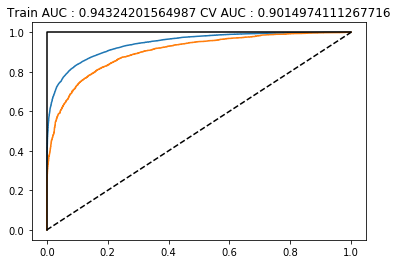

In [33]:
# Define gradient boosting classifier
gbc = GradientBoostingClassifier(max_depth=5,
                                 n_estimators=200,
                                 learning_rate=0.05,
                                 subsample=0.9,
                                 max_features='auto')

start = time.time()
gbc.fit(X_train_cv, y_train_cv)
print('Model Fit Processing Time : ' + str(time.time()-start))
y_predict = gbc.predict(X_train_cv)
y_train_score = gbc.predict_proba(X_train_cv)
y_cv_score = gbc.predict_proba(X_cv)

fpr, tpr, _ = roc_curve(y_train_cv, y_train_score[:,1])
train_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='Train')

fpr, tpr, _ = roc_curve(y_cv, y_cv_score[:,1])
cv_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='CV')

plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0, 0, 1], [0, 1, 1], 'k')
plt.title('Train AUC : ' + str(train_auc) + ' CV AUC : ' + str(cv_auc))

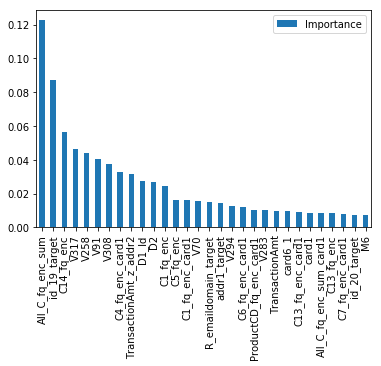

In [34]:
gbc_fi = gbc.feature_importances_
fi_dict = dict(zip(X_train_cv.columns, gbc_fi))
fi_df = pd.DataFrame.from_dict(fi_dict, orient='index').rename(columns={0:'Importance'})
fi_df.sort_values('Importance', ascending=False)[:30].plot.bar()

Iteratively select top 300 most important columns and retrain model

In [35]:
important_cols = list(fi_df.sort_values('Importance', ascending=False).index[:300])

 Model Fit Processing Time : 185.54441833496094


Text(0.5,1,'Tain AUC : 0.9440318952722365 CV AUC : 0.9028160246720661')

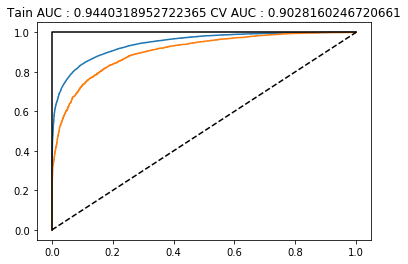

In [36]:
gbc_2 = GradientBoostingClassifier(max_depth=5,
                                 n_estimators=200,
                                 learning_rate=0.05,
                                 subsample=0.9,
                                 max_features='auto')

start = time.time()
gbc_2.fit(X_train_cv[important_cols], y_train_cv)
print(' Model Fit Processing Time : ' + str(time.time()-start))
y_predict = gbc_2.predict(X_train_cv[important_cols])
y_train_score = gbc_2.predict_proba(X_train_cv[important_cols])
y_cv_score = gbc_2.predict_proba(X_cv[important_cols])

fpr, tpr, _ = roc_curve(y_train_cv, y_train_score[:,1])
train_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='Train')

fpr, tpr, _ = roc_curve(y_cv, y_cv_score[:,1])
cv_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='CV')

plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0, 0, 1], [0, 1, 1], 'k')
plt.title('Tain AUC : ' + str(train_auc) + ' CV AUC : ' + str(cv_auc))

## Train Model for submission (on all training data)

 Model Fit Processing Time : 237.62721467018127


Text(0.5,1,'AUC : 0.937791822704883')

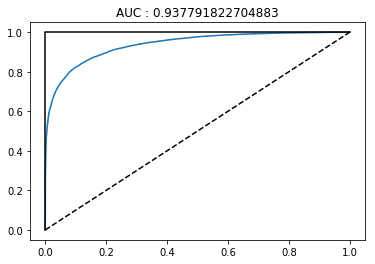

In [37]:
gbc_final = GradientBoostingClassifier(max_depth=5,
                                 n_estimators=200,
                                 learning_rate=0.05,
                                 subsample=0.9,
                                 max_features='auto')

start = time.time()
gbc_final.fit(X[important_cols], y)
print(' Model Fit Processing Time : ' + str(time.time()-start))
y_predict = gbc_final.predict(X[important_cols])
y_score = gbc_final.predict_proba(X[important_cols])

fpr, tpr, _ = roc_curve(y, y_score[:,1])
cv_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='All Train')

plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0, 0, 1], [0, 1, 1], 'k')
plt.title('AUC : ' + str(cv_auc))

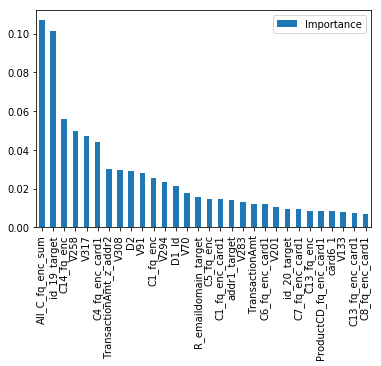

In [38]:
gbc_fi = gbc_final.feature_importances_
fi_dict = dict(zip(X[important_cols].columns, gbc_fi))
fi_df = pd.DataFrame.from_dict(fi_dict, orient='index').rename(columns={0:'Importance'})
fi_df.sort_values('Importance', ascending=False)[:30].plot.bar()

In [39]:
test_y_scores = gbc_final.predict_proba(P_test[important_cols])

In [40]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission["isFraud"] = test_y_scores
sample_submission.set_index('TransactionID').to_csv('submission_github.csv')